# Experiments Variational Repersentation


In [1]:
!pip install numpy matplotlib scipy scikit-learn seaborn pandas tqdm

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached matplotlib-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached scipy-1.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scikit_learn-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
  Using cached contourpy-1.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.51.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (159 kB)
  Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_12_x86

In [2]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence

import numpy as np
from scipy.stats import norm
from sklearn.datasets import make_moons, make_circles

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Model implementation

In [29]:
def get_simple_model(hiddens, activation=nn.ReLU()):
    assert len(hiddens) > 1
    modules = []
    for i, (in_, out_) in enumerate(zip(hiddens[:-1], hiddens[1:])):
        modules.extend([nn.Linear(in_, out_), activation])
    return nn.Sequential(*modules)

In [30]:
# Define of divergence's conjugate function
class Conjugate(nn.Module):
    conjugates = {
        'forward_kl': lambda x: torch.exp(x - 1),
        'reverse_kl': lambda x: -1 - torch.log(-x),
        'js': lambda x: -torch.log(1 - torch.exp(x))
    }
    
    def __init__(self, divergence='forward_kl'):
        super().__init__()
        assert divergence in self.conjugates.keys() 
        self.conjugate = self.conjugates[divergence]

    def forward(self, x):
        return self.conjugate(x)

# Define of divergence's activation function
class Activation(nn.Module):
    activations = {
        'forward_kl': lambda x: x,
        'reverse_kl': lambda x: -torch.exp(-x),
        'js': lambda x: -torch.log(1 + torch.exp(-x))
    }
    
    def __init__(self, divergence='forward_kl'):
        super().__init__()
        assert divergence in self.activations.keys() 
        self.activation = self.activations[divergence]

    def forward(self, x):
        return self.activation(x)

In [36]:
class Conditional(nn.Module):
    def __init__(self, in_dim, gamma=None):
        super().__init__()
        
        self.in_dim = in_dim
        self.net =  get_simple_model([in_dim, 256, 256]) # , nn.ELU())
        self.last = nn.Linear(256, 2 * in_dim)
        
        if gamma is not None:
            for module in self.net:
                self._init_weights_net(module)
            self._init_weights_net(self.last)
            self._init_weights_gamma(self.last, torch.tensor(gamma))
        else:
            for module in self.net:
                if isinstance(module, nn.Linear):
                    nn.init.xavier_uniform_(module.weight)
            nn.init.xavier_uniform_(self.last.weight)


    def forward(self, y):
        mu, log_std = self.last(self.net(y)).chunk(2, dim=1)
        return torch.exp(log_std) * self._prior(mu.shape, y.device) + mu

    def _prior(self, size, device):
        return Normal(.0, 1.).sample(size).to(device)

    def log_prob(self, x, y):
        mu, log_std = self.last(self.net(y)).chunk(2, dim=1)
        return Normal(mu, torch.exp(log_std)).log_prob(x)

    def _init_weights_net(self, module):
        if isinstance(module, nn.Linear):
            nn.init.eye_(module.weight)
            nn.init.zeros_(module.bias)
            
    def _init_weights_gamma(self, module, gamma):
        if isinstance(module, nn.Linear):
            module.bias.data[len(module.bias) // 2:].fill_(torch.log(gamma))
    
############## TEST ##################
test_in_dim = 2
test_latent_dim = 2
test_cond = Conditional(test_in_dim, 100)

test_x = torch.ones((2, test_in_dim))
test_cond(test_x)
test_cond

Conditional(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
  )
  (last): Linear(in_features=256, out_features=4, bias=True)
)

In [37]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, divergence='forward_kl'):
        super().__init__()
        self.in_dim = in_dim

        self.net = get_simple_model([2 * in_dim, 256, 256], nn.LeakyReLU(0.1))
        self.last = nn.Linear(256, 1)
        self.activation = Activation(divergence)
        self.conjugate = Conjugate(divergence)

    def forward(self, x, y, conjugate=False):
        x_y = torch.concat([x, y], dim=1)
        x_y = self.activation(self.last(self.net(x_y)))
        return x_y if not conjugate else self.conjugate(x_y)

############## TEST ##################
test_in_dim = 2
test_disc = Discriminator(test_in_dim)

test_x = torch.rand((4, test_in_dim))
test_y = torch.rand((4, test_in_dim))
test_disc(test_x, test_y)
test_disc

Discriminator(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (last): Linear(in_features=256, out_features=1, bias=True)
  (activation): Activation()
  (conjugate): Conjugate()
)

In [92]:
class AdversarialIPFPTrainer:
    def __init__(self, batch_size, cond_p, cond_q, disc_b, disc_f, lr_gen=None, lr_disc=None):
        self.batch_size = batch_size
        self.dim  = cond_p.in_dim
        
        self.cond_p = cond_p # x|y
        self.cond_q = cond_q # y|x
        self.disc_b = disc_b
        self.disc_f = disc_f

        if lr_gen is None:
            lr_gen = {
                'forward': 1e-4,
                'backward': 1e-4,
            }
        if lr_disc is None:
            lr_disc = {
                'forward': 1e-4,
                'backward': 1e-4,
            }

        self.optim_gen = {
            'forward': torch.optim.Adam(cond_q.parameters(), lr=lr_gen['forward'], weight_decay=0.1, betas=(0.5, 0.999)),
            'backward': torch.optim.Adam(cond_p.parameters(), lr=lr_gen['backward'], weight_decay=0.1, betas=(0.5, 0.999))
        } 
        self.optim_disc = {
            'forward': torch.optim.Adam(disc_f.parameters(), lr=lr_disc['forward'], weight_decay=0.5, betas=(0.5, 0.999)),
            'backward': torch.optim.Adam(disc_b.parameters(), lr=lr_disc['backward'], weight_decay=0.5, betas=(0.5, 0.999)),
        } 
        
    def _backward_step(self, x, y):
        loss_cond = self._train_step_gen(y, self.cond_p, self.disc_b, self.optim_gen, step='backward')
        loss_disc = self._train_step_disc(y, x, self.cond_p, self.cond_q, self.disc_b, self.optim_disc, step='backward')
        return loss_cond, loss_disc

    def _forward_step(self, x, y):
        loss_cond = self._train_step_gen(x, self.cond_q, self.disc_f, self.optim_gen, step='forward')
        loss_disc = self._train_step_disc(x, y, self.cond_q, self.cond_p, self.disc_f, self.optim_disc, step='forward')
        return loss_cond, loss_disc
    
    def _train_step_gen(self, latent, cond, disc, optim, step):
        optim[step].zero_grad()

        # Generate fake samples
        generated = cond(latent)

        if step == 'backward':
            loss = disc(generated, latent).mean()
        else:
            loss = disc(latent, generated).mean()
        
        loss.backward()
        optim[step].step()
        return loss.detach().cpu().item()
    
    def _train_step_disc(self, latent1, latent2, cond, cond_fixed, disc, optim, step):
        optim[step].zero_grad()

        # calc training cond loss
        generated = cond(latent1)

        if step == 'backward':
            loss_training = disc(generated, latent1).mean() # В случае backward в Discriminator подается (y, x)
        else:
            loss_training = disc(latent1, generated).mean()

        # calc fixed cond loss
        with torch.no_grad():
            generated = cond_fixed(latent2)
            
        if step == 'backward':
            loss_fixed = disc(latent2, generated, conjugate=True).mean()
        else:
            loss_fixed = disc(generated, latent2, conjugate=True).mean()
        

        # combine
        loss = loss_fixed - loss_training
        loss.backward()
        optim[step].step()
            
        return -loss.detach().cpu().item()
        
@torch.no_grad()     
def compute_kl_divergence(x, y, cond, cond_fixed, marg, marg_fixed):
    lob_prob_marg = marg.log_prob(x)
    log_prob_cond = cond.log_prob(y, x)
    log_probs = lob_prob_marg + log_prob_cond

    lob_prob_marg_fixed = marg_fixed.log_prob(y)
    log_prob_cond_fixed = cond_fixed.log_prob(x, y)
    log_probs_fixed = lob_prob_marg_fixed + log_prob_cond_fixed
    # print(log_probs.mean(), log_probs_fixed.mean())
    
    kl_div = torch.exp(log_probs) * (log_probs - log_probs_fixed - torch.log(torch.tensor(0.01)))
    return kl_div.sum()

Backward:
$$
\mathbb{E}_{y\sim\pi_1(y)}\mathbb{E}_{x\sim p(x|y)}D(x,y) - \mathbb{E}_{x\sim\pi_0(x)}\mathbb{E}_{y\sim q^*(y|x)}e^{D(x,y)-1}
$$

Forward:
$$
\mathbb{E}_{x\sim\pi_0(x)}\mathbb{E}_{y\sim q(y|x)}D(x,y) - \mathbb{E}_{y\sim\pi_1(y)}\mathbb{E}_{x\sim p^*(x|y)}e^{D(x,y)-1}
$$

Algorithm:
1. Sample real $x$, $y$
2. Sample fake $x$, $y$ from conditional pdf $p(x|y)$ and $q(y|x)$
3. Calculate expectation loss

### For onevariate dataset calculate kl div using marginal and conditional

In [93]:
class OneVariateDataset(Dataset):
    def __init__(self, size, marg_x, marg_y):
        self.size = size
        self.x = marg_x.sample([size, 1])
        self.y = marg_y.sample([size, 1])

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):        
        return self.x[idx], self.y[idx]

In [103]:
# Models parameters
data_dim = 1
divergence='forward_kl'

marginal_x = Normal(-2, 3)
marginal_y = Normal(5, 1)
conditional_p = Conditional(data_dim).to(device)
conditional_q = Conditional(data_dim, gamma=5).to(device)
discriminator_backward = Discriminator(data_dim, divergence=divergence).to(device)
discriminator_forward = Discriminator(data_dim, divergence=divergence).to(device)

# Trainer and dataloader parameters
batch_size = 4098

dataset = OneVariateDataset(20_000, marginal_x, marginal_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
trainer = AdversarialIPFPTrainer(
    batch_size,
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_gen={'forward': 1e-3, 'backward': 1e-3},
    lr_disc={'forward': 1e-4, 'backward': 1e-4}
)

losses = {'cond_p': [], 'cond_q': [], 'disc_b': [], 'disc_f': []}

for epoch in range(200):
    avg_loss_cond_p, avg_loss_cond_q = 0, 0
    avg_loss_disc_b, avg_loss_disc_f = 0, 0

    if (epoch + 1) % 20 == 0:
        print(f'{"="*5} backward {"="*5}')
    for i, batch in enumerate(dataloader):
        if (epoch + 1) % 20 == 0:
            avg_kl_div_b = 0

        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        loss_cond_p, loss_disc_b = trainer._backward_step(x, y)
        avg_loss_cond_p += loss_cond_p
        avg_loss_disc_b += loss_disc_b
        avg_kl_div_b += compute_kl_divergence(y, x, trainer.cond_p, trainer.cond_q, marginal_y, marginal_x)
        
        if (epoch + 1) % 20 == 0:
            print(f'Iteration: {i + 1}; KL(p||q): {avg_kl_div_b / batch_size}')

    if (epoch + 1) % 20 == 0:
        print(f'{"="*5} forward {"="*5}')    
    for i, batch in enumerate(dataloader):
        if (epoch + 1) % 20 == 0:
            avg_kl_div_f = 0
        
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        loss_cond_q, loss_disc_f = trainer._forward_step(x, y)
        avg_loss_cond_q += loss_cond_q
        avg_loss_disc_f += loss_disc_f
        avg_kl_div_f += compute_kl_divergence(x, y, trainer.cond_q, trainer.cond_p, marginal_x, marginal_y)

        if (epoch + 1) % 20 == 0:
            print(f'Iteration: {i + 1}; KL(q||p): {avg_kl_div_f / batch_size}')
    
    losses['cond_p'].append(avg_loss_cond_p / len(dataloader))
    losses['cond_q'].append(avg_loss_cond_q / len(dataloader))
    losses['disc_b'].append(avg_loss_disc_b / len(dataloader))
    losses['disc_f'].append(avg_loss_disc_f / len(dataloader))
    
# print(f'Iteration: {epoch + 1}; cond_p: {losses["cond_p"][-1]}, cond_q: {losses["cond_q"][-1]}, disc_f: {losses["disc_f"][-1]}, disc_b: {losses["disc_b"][-1]}')

===== backward =====
Iteration: 1; KL(p||q): 0.22259670495986938
Iteration: 2; KL(p||q): 0.21440483629703522
Iteration: 3; KL(p||q): 0.21628117561340332
Iteration: 4; KL(p||q): 0.20808866620063782
Iteration: 5; KL(p||q): 0.17090965807437897
===== forward =====
Iteration: 1; KL(q||p): 0.016528049483895302
Iteration: 2; KL(q||p): 0.016738366335630417
Iteration: 3; KL(q||p): 0.01653827168047428
Iteration: 4; KL(q||p): 0.016581805422902107
Iteration: 5; KL(q||p): 0.01488593127578497
===== backward =====
Iteration: 1; KL(p||q): 0.17229801416397095
Iteration: 2; KL(p||q): 0.17120462656021118
Iteration: 3; KL(p||q): 0.16893725097179413
Iteration: 4; KL(p||q): 0.16255056858062744
Iteration: 5; KL(p||q): 0.14171764254570007
===== forward =====
Iteration: 1; KL(q||p): 0.020059719681739807
Iteration: 2; KL(q||p): 0.020109357312321663
Iteration: 3; KL(q||p): 0.020101698115468025
Iteration: 4; KL(q||p): 0.02017972245812416
Iteration: 5; KL(q||p): 0.017959708347916603
===== backward =====
Iteration:

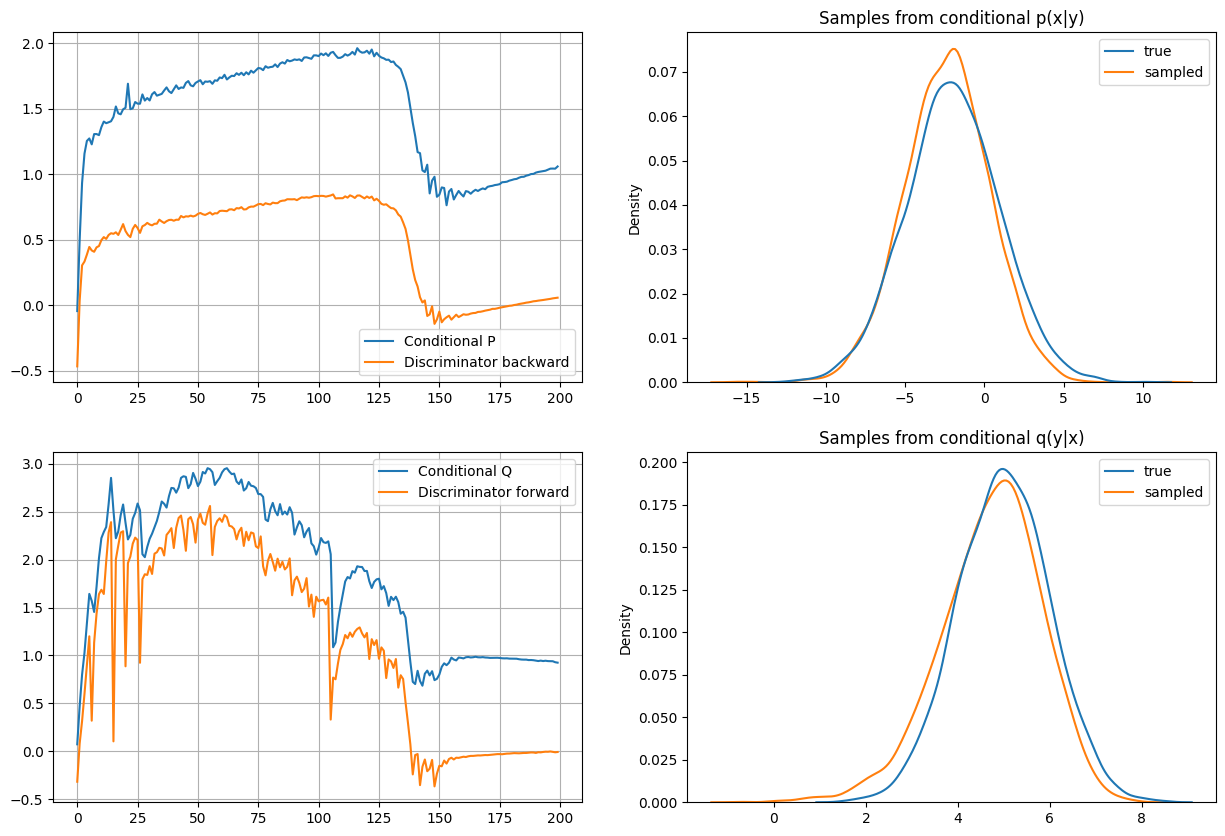

In [104]:
conditional_q.to('cpu')
conditional_p.to('cpu')

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# Plot losses
axs[0][0].plot(losses['cond_p'], label='Conditional P')
axs[0][0].plot(losses['disc_b'], label='Discriminator backward')
axs[0][0].grid()
axs[0][0].legend()

axs[1][0].plot(losses['cond_q'], label='Conditional Q')
axs[1][0].plot(losses['disc_f'], label='Discriminator forward')
axs[1][0].grid()
axs[1][0].legend()

# Plot samples 
n_samples = 4098
true_x = marginal_x.sample([n_samples, 1])
true_y = marginal_y.sample([n_samples, 1])

conditional_q.eval()
sampled_y = conditional_q(true_x).detach().numpy()
df_y = {'true': true_y.squeeze(), 'sampled': sampled_y.squeeze()}
df_y = pd.DataFrame(df_y)
sns.kdeplot(df_y, ax=axs[1][1])
axs[1][1].set_title("Samples from conditional q(y|x)")

conditional_p.eval()
sampled_x = conditional_p(true_y).detach().numpy()
df_x = {'true': true_x.squeeze(), 'sampled': sampled_x.squeeze()}
df_x = pd.DataFrame(df_x)
sns.kdeplot(df_x, ax=axs[0][1])
axs[0][1].set_title("Samples from conditional p(x|y)")

plt.show()

### For twovariate dataset

In [109]:
def visualize(cond_p, cond_q, dataset):
    circles, moons = dataset.circles[:2_000], dataset.moons[:2_000]
    
    fake_circles = pd.DataFrame(cond_p(moons).detach().numpy(), columns=['x', 'y'])
    fake_moons = pd.DataFrame(cond_q(circles).detach().numpy(), columns=['x', 'y'])
    circles = pd.DataFrame(circles, columns=['x', 'y'])
    moons = pd.DataFrame(moons, columns=['x', 'y'])
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 4))
    sns.kdeplot(circles, x='x', y='y', fill=True, ax=axs[0][0])
    axs[0][0].set_title("Circles")
    sns.kdeplot(fake_circles, x='x', y='y', fill=True, color='r', ax=axs[0][1])
    axs[0][1].set_title("Fake Circles")
    sns.kdeplot(moons, x='x', y='y', fill=True, ax=axs[1][0])
    axs[1][0].set_title("Moons")
    sns.kdeplot(fake_moons, x='x', y='y', fill=True, color='r', ax=axs[1][1])
    axs[1][1].set_title("Fake Moons")
    plt.show()

In [110]:
class MoonCircleDataset(Dataset):
    def __init__(self, size):
        self.size = size
        self.circles = torch.tensor(make_circles(size, noise=0.05, factor=0.5)[0], dtype=torch.float)
        self.moons = torch.tensor(make_moons(size, noise=0.05)[0], dtype=torch.float)

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):        
        return self.circles[idx], self.moons[idx]

## Training

In [129]:
# Models parameters
data_dim = 2
divergence='forward_kl'

conditional_p = Conditional(data_dim)
conditional_q = Conditional(data_dim, gamma=5)
discriminator_backward = Discriminator(data_dim, divergence=divergence)
discriminator_forward = Discriminator(data_dim, divergence=divergence)


# Trainer and dataloader parameters
batch_size = 4098

dataset = MoonCircleDataset(20_000)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
trainer = AdversarialIPFPTrainer(
    batch_size,
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_gen={'forward': 1e-3, 'backward': 1e-3},
    lr_disc={'forward': 1e-4, 'backward': 1e-4}
)

losses = {'cond_p': [], 'cond_q': [], 'disc_b': [], 'disc_f': []}

for epoch in range(100):
    avg_loss_cond_p, avg_loss_cond_q = 0, 0
    avg_loss_disc_b, avg_loss_disc_f = 0, 0
    
    for batch in dataloader:
        x, y = batch
        
        loss_cond_p, loss_disc_b = trainer._backward_step(x, y)
        avg_loss_cond_p += loss_cond_p
        avg_loss_disc_b += loss_disc_b
        
        loss_cond_q, loss_disc_f = trainer._forward_step(x, y)
        avg_loss_cond_q += loss_cond_q
        avg_loss_disc_f += loss_disc_f
    
    losses['cond_p'].append(avg_loss_cond_p / batch_size / len(dataloader))
    losses['cond_q'].append(avg_loss_cond_q / batch_size / len(dataloader))
    losses['disc_b'].append(avg_loss_disc_b / batch_size / len(dataloader))
    losses['disc_f'].append(avg_loss_disc_f / batch_size / len(dataloader))


    if (epoch + 1) % 10 == 0:
        print(f'Iteration: {epoch + 1}; cond_p: {losses["cond_p"][-1]}, cond_q: {losses["cond_q"][-1]}, disc_f: {losses["disc_f"][-1]}, disc_b: {losses["disc_b"][-1]}')

Iteration: 10; cond_p: 0.00011693521381413547, cond_q: 0.0008690368029593025, disc_f: 0.0006426060007746014, disc_b: 3.438172775573879e-05
Iteration: 20; cond_p: 0.00027048316101960403, cond_q: 0.001415568249815554, disc_f: 0.0010634796511201873, disc_b: 0.000157549731495207
Iteration: 30; cond_p: 0.00039064464131583816, cond_q: 0.0013520855854754917, disc_f: 0.0010134579903792033, disc_b: 0.00022553753829572537
Iteration: 40; cond_p: 0.0004049727252310459, cond_q: 0.0010334798916192564, disc_f: 0.0007559550454291906, disc_b: 0.00019637173184422298
Iteration: 50; cond_p: 0.00035572419113040027, cond_q: 0.0006994549619563909, disc_f: 0.00044109975494600727, disc_b: 0.00012663149903494302
Iteration: 60; cond_p: 0.0003095640735896172, cond_q: 0.00044567584991455077, disc_f: 0.00020885153070434004, disc_b: 7.167629290348498e-05
Iteration: 70; cond_p: 0.00028303817401809653, cond_q: 0.00029773738338867005, disc_f: 6.733987900383477e-05, disc_b: 4.339902909457131e-05
Iteration: 80; cond_p: 0

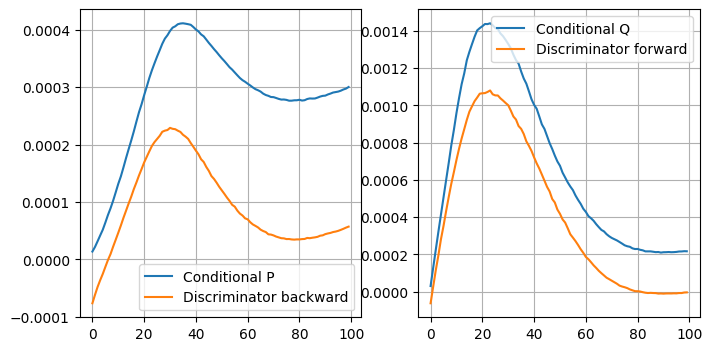

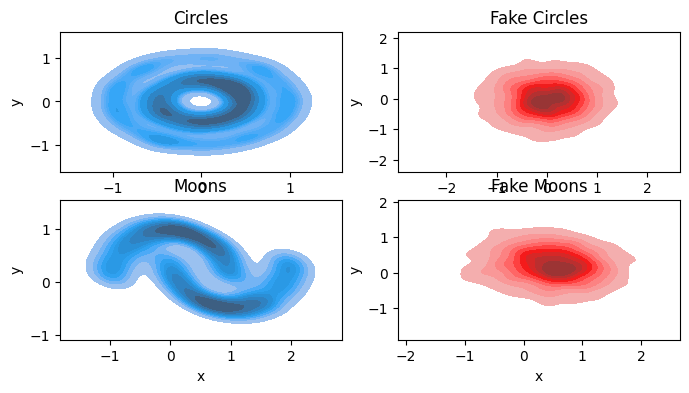

In [130]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# Plot losses
axs[0].plot(losses['cond_p'], label='Conditional P')
axs[0].plot(losses['disc_b'], label='Discriminator backward')
axs[0].grid()
axs[0].legend()

axs[1].plot(losses['cond_q'], label='Conditional Q')
axs[1].plot(losses['disc_f'], label='Discriminator forward')
axs[1].grid()
axs[1].legend()

# plt.grid()
# plt.legend()
visualize(conditional_p, conditional_q, dataset)

## Bimofal distribution test

In [5]:
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions.categorical import Categorical

In [111]:
# Models parameters
data_dim = 1
divergence='forward_kl'

marginal_x = Normal(0, 1)
marginal_y = MixtureSameFamily(
    Categorical(torch.tensor([0.5, 0.5], device=device, dtype=torch.float)), 
    Normal(torch.tensor([20, -20], device=device, dtype=torch.float), torch.tensor([0.5, 0.5], device=device, dtype=torch.float))
)

conditional_p = Conditional(data_dim).to(device)
conditional_q = Conditional(data_dim, gamma=5).to(device)
discriminator_backward = Discriminator(data_dim, divergence=divergence).to(device)
discriminator_forward = Discriminator(data_dim, divergence=divergence).to(device)

# Trainer and dataloader parameters
batch_size = 4098

dataset = OneVariateDataset(20_000, marginal_x, marginal_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
trainer = AdversarialIPFPTrainer(
    batch_size,
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_gen={'forward': 1e-3, 'backward': 1e-3},
    lr_disc={'forward': 1e-4, 'backward': 1e-4}
)

losses = {'cond_p': [], 'cond_q': [], 'disc_b': [], 'disc_f': []}

for epoch in range(200):
    avg_loss_cond_p, avg_loss_cond_q = 0, 0
    avg_loss_disc_b, avg_loss_disc_f = 0, 0

    if (epoch + 1) % 20 == 0:
        print(f'{"="*5} backward {"="*5}')
    for i, batch in enumerate(dataloader):
        if (epoch + 1) % 20 == 0:
            avg_kl_div_b = 0

        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        loss_cond_p, loss_disc_b = trainer._backward_step(x, y)
        avg_loss_cond_p += loss_cond_p
        avg_loss_disc_b += loss_disc_b
        avg_kl_div_b += compute_kl_divergence(y, x, trainer.cond_p, trainer.cond_q, marginal_y, marginal_x)
        
        if (epoch + 1) % 20 == 0:
            print(f'Iteration: {i + 1}; KL(p||q): {avg_kl_div_b / batch_size}')

    if (epoch + 1) % 20 == 0:
        print(f'{"="*5} forward {"="*5}')    
    for i, batch in enumerate(dataloader):
        if (epoch + 1) % 20 == 0:
            avg_kl_div_f = 0
        
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        loss_cond_q, loss_disc_f = trainer._forward_step(x, y)
        avg_loss_cond_q += loss_cond_q
        avg_loss_disc_f += loss_disc_f
        avg_kl_div_f += compute_kl_divergence(x, y, trainer.cond_q, trainer.cond_p, marginal_x, marginal_y)

        if (epoch + 1) % 20 == 0:
            print(f'Iteration: {i + 1}; KL(q||p): {avg_kl_div_f / batch_size}')
    
    losses['cond_p'].append(avg_loss_cond_p / len(dataloader))
    losses['cond_q'].append(avg_loss_cond_q / len(dataloader))
    losses['disc_b'].append(avg_loss_disc_b / len(dataloader))
    losses['disc_f'].append(avg_loss_disc_f / len(dataloader))
    
# print(f'Iteration: {epoch + 1}; cond_p: {losses["cond_p"][-1]}, cond_q: {losses["cond_q"][-1]}, disc_f: {losses["disc_f"][-1]}, disc_b: {losses["disc_b"][-1]}')

===== backward =====
Iteration: 1; KL(p||q): 0.3231509029865265
Iteration: 2; KL(p||q): 0.34777897596359253
Iteration: 3; KL(p||q): 0.3704327642917633
Iteration: 4; KL(p||q): 0.41780397295951843
Iteration: 5; KL(p||q): 0.40879732370376587
===== forward =====
Iteration: 1; KL(q||p): -3.447715062065981e-05
Iteration: 2; KL(q||p): -3.553785791154951e-05
Iteration: 3; KL(q||p): -3.6207256925990805e-05
Iteration: 4; KL(q||p): -3.602902143029496e-05
Iteration: 5; KL(q||p): -3.1966603273758665e-05
===== backward =====
Iteration: 1; KL(p||q): 0.7930352091789246
Iteration: 2; KL(p||q): 0.7682173848152161
Iteration: 3; KL(p||q): 0.7377052903175354
Iteration: 4; KL(p||q): 0.7197861671447754
Iteration: 5; KL(p||q): 0.6023472547531128
===== forward =====
Iteration: 1; KL(q||p): -0.0001723472960293293
Iteration: 2; KL(q||p): -0.00017255655257031322
Iteration: 3; KL(q||p): -0.000174293527379632
Iteration: 4; KL(q||p): -0.00016344990581274033
Iteration: 5; KL(q||p): -0.00015157475718297064
===== backw

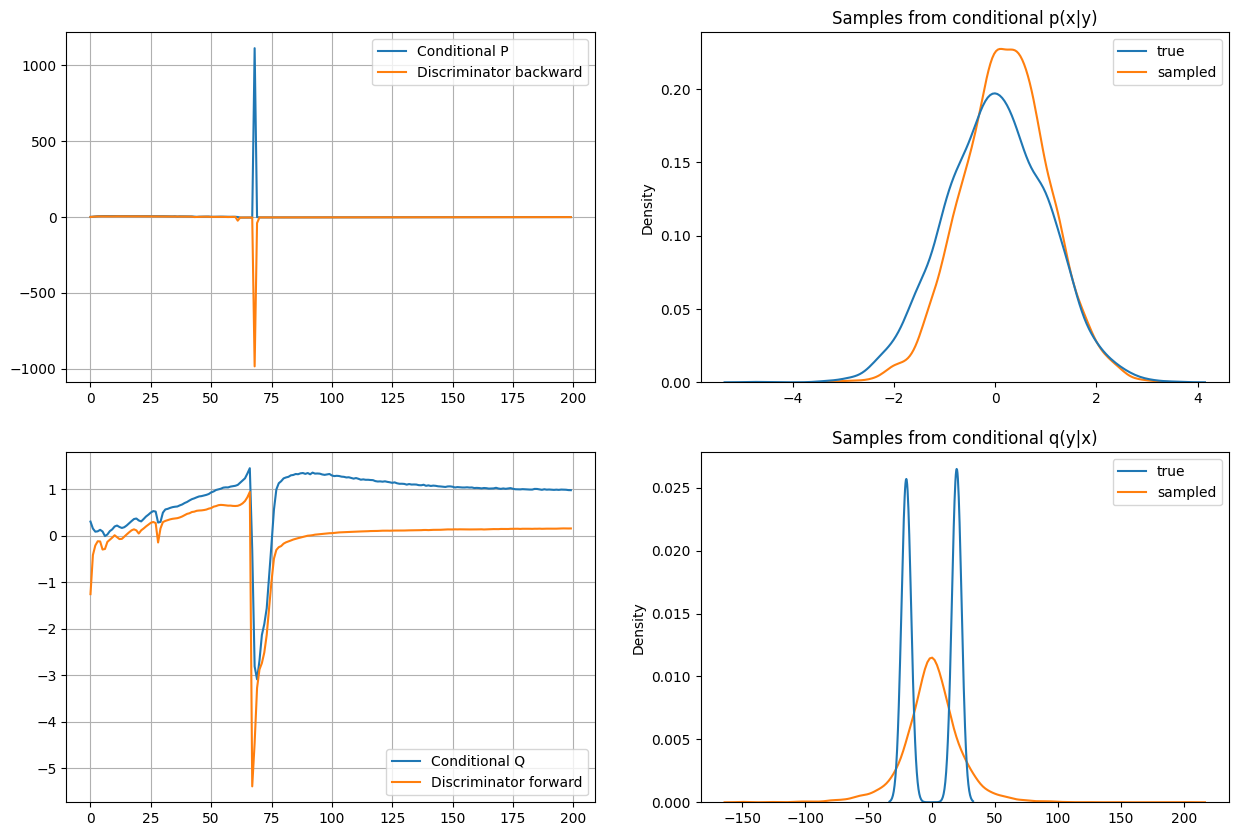

In [114]:
conditional_q.to('cpu')
conditional_p.to('cpu')

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# Plot losses
axs[0][0].plot(losses['cond_p'], label='Conditional P')
axs[0][0].plot(losses['disc_b'], label='Discriminator backward')
axs[0][0].grid()
axs[0][0].legend()

axs[1][0].plot(losses['cond_q'], label='Conditional Q')
axs[1][0].plot(losses['disc_f'], label='Discriminator forward')
axs[1][0].grid()
axs[1][0].legend()

# Plot samples 
n_samples = 4098
true_x = marginal_x.sample([n_samples, 1]).cpu()
true_y = marginal_y.sample([n_samples, 1]).cpu()

conditional_q.eval()
sampled_y = conditional_q(true_x).detach().numpy()
df_y = {'true': true_y.squeeze(), 'sampled': sampled_y.squeeze()}
df_y = pd.DataFrame(df_y)
sns.kdeplot(df_y, ax=axs[1][1])
axs[1][1].set_title("Samples from conditional q(y|x)")

conditional_p.eval()
sampled_x = conditional_p(true_y).detach().numpy()
df_x = {'true': true_x.squeeze(), 'sampled': sampled_x.squeeze()}
df_x = pd.DataFrame(df_x)
sns.kdeplot(df_x, ax=axs[0][1])
axs[0][1].set_title("Samples from conditional p(x|y)")

plt.show()

In [115]:
# Models parameters
data_dim = 1
divergence='forward_kl'

marginal_x = Normal(0, 1)
marginal_y = MixtureSameFamily(
    Categorical(torch.tensor([0.5, 0.5], device=device, dtype=torch.float)), 
    Normal(torch.tensor([1.8, -1.9], device=device, dtype=torch.float), torch.tensor([0.6, 0.6], device=device, dtype=torch.float))
)

conditional_p = Conditional(data_dim).to(device)
conditional_q = Conditional(data_dim, gamma=5).to(device)
discriminator_backward = Discriminator(data_dim, divergence=divergence).to(device)
discriminator_forward = Discriminator(data_dim, divergence=divergence).to(device)

# Trainer and dataloader parameters
batch_size = 4098

dataset = OneVariateDataset(20_000, marginal_x, marginal_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
trainer = AdversarialIPFPTrainer(
    batch_size,
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_gen={'forward': 1e-3, 'backward': 1e-3},
    lr_disc={'forward': 1e-4, 'backward': 1e-4}
)

losses = {'cond_p': [], 'cond_q': [], 'disc_b': [], 'disc_f': []}

for epoch in range(200):
    avg_loss_cond_p, avg_loss_cond_q = 0, 0
    avg_loss_disc_b, avg_loss_disc_f = 0, 0

    if (epoch + 1) % 20 == 0:
        print(f'{"="*5} backward {"="*5}')
    for i, batch in enumerate(dataloader):
        if (epoch + 1) % 20 == 0:
            avg_kl_div_b = 0

        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        loss_cond_p, loss_disc_b = trainer._backward_step(x, y)
        avg_loss_cond_p += loss_cond_p
        avg_loss_disc_b += loss_disc_b
        avg_kl_div_b += compute_kl_divergence(y, x, trainer.cond_p, trainer.cond_q, marginal_y, marginal_x)
        
        if (epoch + 1) % 20 == 0:
            print(f'Iteration: {i + 1}; KL(p||q): {avg_kl_div_b / batch_size}')

    if (epoch + 1) % 20 == 0:
        print(f'{"="*5} forward {"="*5}')    
    for i, batch in enumerate(dataloader):
        if (epoch + 1) % 20 == 0:
            avg_kl_div_f = 0
        
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        loss_cond_q, loss_disc_f = trainer._forward_step(x, y)
        avg_loss_cond_q += loss_cond_q
        avg_loss_disc_f += loss_disc_f
        avg_kl_div_f += compute_kl_divergence(x, y, trainer.cond_q, trainer.cond_p, marginal_x, marginal_y)

        if (epoch + 1) % 20 == 0:
            print(f'Iteration: {i + 1}; KL(q||p): {avg_kl_div_f / batch_size}')
    
    losses['cond_p'].append(avg_loss_cond_p / len(dataloader))
    losses['cond_q'].append(avg_loss_cond_q / len(dataloader))
    losses['disc_b'].append(avg_loss_disc_b / len(dataloader))
    losses['disc_f'].append(avg_loss_disc_f / len(dataloader))
    
# print(f'Iteration: {epoch + 1}; cond_p: {losses["cond_p"][-1]}, cond_q: {losses["cond_q"][-1]}, disc_f: {losses["disc_f"][-1]}, disc_b: {losses["disc_b"][-1]}')

===== backward =====
Iteration: 1; KL(p||q): 0.4350663125514984
Iteration: 2; KL(p||q): 0.4349958300590515
Iteration: 3; KL(p||q): 0.42893680930137634
Iteration: 4; KL(p||q): 0.43973568081855774
Iteration: 5; KL(p||q): 0.385203093290329
===== forward =====
Iteration: 1; KL(q||p): 0.08799351751804352
Iteration: 2; KL(q||p): 0.08853914588689804
Iteration: 3; KL(q||p): 0.08794418722391129
Iteration: 4; KL(q||p): 0.08877120912075043
Iteration: 5; KL(q||p): 0.07824566215276718
===== backward =====
Iteration: 1; KL(p||q): 0.4048675000667572
Iteration: 2; KL(p||q): 0.4017333984375
Iteration: 3; KL(p||q): 0.3994523584842682
Iteration: 4; KL(p||q): 0.4071998596191406
Iteration: 5; KL(p||q): 0.357839435338974
===== forward =====
Iteration: 1; KL(q||p): 0.10883531719446182
Iteration: 2; KL(q||p): 0.10820963233709335
Iteration: 3; KL(q||p): 0.10923568159341812
Iteration: 4; KL(q||p): 0.10930471867322922
Iteration: 5; KL(q||p): 0.09624818712472916
===== backward =====
Iteration: 1; KL(p||q): 0.3900

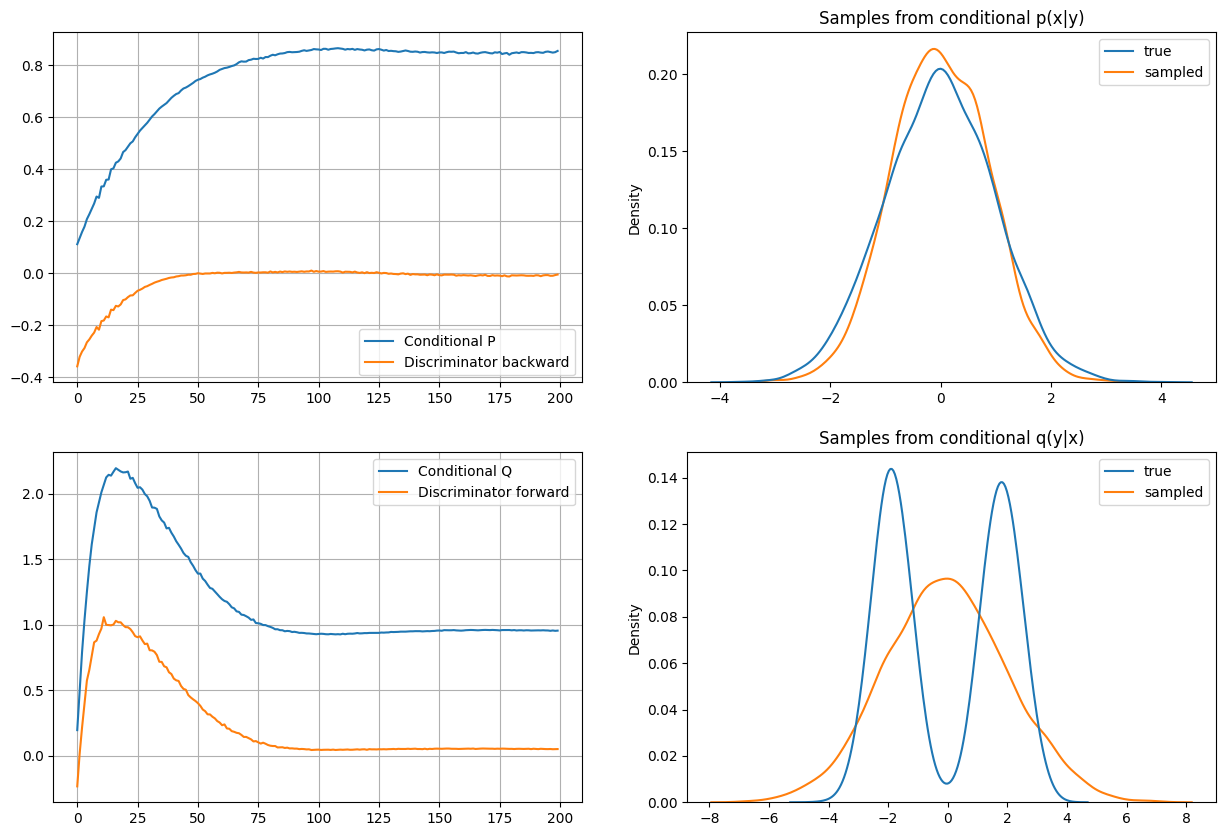

In [116]:
conditional_q.to('cpu')
conditional_p.to('cpu')

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# Plot losses
axs[0][0].plot(losses['cond_p'], label='Conditional P')
axs[0][0].plot(losses['disc_b'], label='Discriminator backward')
axs[0][0].grid()
axs[0][0].legend()

axs[1][0].plot(losses['cond_q'], label='Conditional Q')
axs[1][0].plot(losses['disc_f'], label='Discriminator forward')
axs[1][0].grid()
axs[1][0].legend()

# Plot samples 
n_samples = 4098
true_x = marginal_x.sample([n_samples, 1]).cpu()
true_y = marginal_y.sample([n_samples, 1]).cpu()

conditional_q.eval()
sampled_y = conditional_q(true_x).detach().numpy()
df_y = {'true': true_y.squeeze(), 'sampled': sampled_y.squeeze()}
df_y = pd.DataFrame(df_y)
sns.kdeplot(df_y, ax=axs[1][1])
axs[1][1].set_title("Samples from conditional q(y|x)")

conditional_p.eval()
sampled_x = conditional_p(true_y).detach().numpy()
df_x = {'true': true_x.squeeze(), 'sampled': sampled_x.squeeze()}
df_x = pd.DataFrame(df_x)
sns.kdeplot(df_x, ax=axs[0][1])
axs[0][1].set_title("Samples from conditional p(x|y)")

plt.show()

In [118]:
# Models parameters
data_dim = 1
divergence='forward_kl'

marginal_x = Normal(0, 1)
marginal_y = MixtureSameFamily(
    Categorical(torch.tensor([1/3, 1/3, 1/3], device=device, dtype=torch.float)), 
    Normal(torch.tensor([5, 2, -5], device=device, dtype=torch.float), torch.tensor([0.5, 0.5,  0.5], device=device, dtype=torch.float))
)

conditional_p = Conditional(data_dim).to(device)
conditional_q = Conditional(data_dim, gamma=5).to(device)
discriminator_backward = Discriminator(data_dim, divergence=divergence).to(device)
discriminator_forward = Discriminator(data_dim, divergence=divergence).to(device)

# Trainer and dataloader parameters
batch_size = 4098

dataset = OneVariateDataset(20_000, marginal_x, marginal_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
trainer = AdversarialIPFPTrainer(
    batch_size,
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_gen={'forward': 1e-3, 'backward': 1e-3},
    lr_disc={'forward': 1e-4, 'backward': 1e-4}
)

losses = {'cond_p': [], 'cond_q': [], 'disc_b': [], 'disc_f': []}

for epoch in range(200):
    avg_loss_cond_p, avg_loss_cond_q = 0, 0
    avg_loss_disc_b, avg_loss_disc_f = 0, 0

    if (epoch + 1) % 20 == 0:
        print(f'{"="*5} backward {"="*5}')
    for i, batch in enumerate(dataloader):
        if (epoch + 1) % 20 == 0:
            avg_kl_div_b = 0

        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        loss_cond_p, loss_disc_b = trainer._backward_step(x, y)
        avg_loss_cond_p += loss_cond_p
        avg_loss_disc_b += loss_disc_b
        avg_kl_div_b += compute_kl_divergence(y, x, trainer.cond_p, trainer.cond_q, marginal_y, marginal_x)
        
        if (epoch + 1) % 20 == 0:
            print(f'Iteration: {i + 1}; KL(p||q): {avg_kl_div_b / batch_size}')

    if (epoch + 1) % 20 == 0:
        print(f'{"="*5} forward {"="*5}')    
    for i, batch in enumerate(dataloader):
        if (epoch + 1) % 20 == 0:
            avg_kl_div_f = 0
        
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        loss_cond_q, loss_disc_f = trainer._forward_step(x, y)
        avg_loss_cond_q += loss_cond_q
        avg_loss_disc_f += loss_disc_f
        avg_kl_div_f += compute_kl_divergence(x, y, trainer.cond_q, trainer.cond_p, marginal_x, marginal_y)

        if (epoch + 1) % 20 == 0:
            print(f'Iteration: {i + 1}; KL(q||p): {avg_kl_div_f / batch_size}')
    
    losses['cond_p'].append(avg_loss_cond_p / len(dataloader))
    losses['cond_q'].append(avg_loss_cond_q / len(dataloader))
    losses['disc_b'].append(avg_loss_disc_b / len(dataloader))
    losses['disc_f'].append(avg_loss_disc_f / len(dataloader))
    
# print(f'Iteration: {epoch + 1}; cond_p: {losses["cond_p"][-1]}, cond_q: {losses["cond_q"][-1]}, disc_f: {losses["disc_f"][-1]}, disc_b: {losses["disc_b"][-1]}')

===== backward =====
Iteration: 1; KL(p||q): 0.34295782446861267
Iteration: 2; KL(p||q): 0.33904847502708435
Iteration: 3; KL(p||q): 0.33148154616355896
Iteration: 4; KL(p||q): 0.3363012969493866
Iteration: 5; KL(p||q): 0.29730114340782166
===== forward =====
Iteration: 1; KL(q||p): 0.06355134397745132
Iteration: 2; KL(q||p): 0.06289282441139221
Iteration: 3; KL(q||p): 0.06289134919643402
Iteration: 4; KL(q||p): 0.06218509376049042
Iteration: 5; KL(q||p): 0.05583268404006958
===== backward =====
Iteration: 1; KL(p||q): 0.31210044026374817
Iteration: 2; KL(p||q): 0.30936554074287415
Iteration: 3; KL(p||q): 0.3098650276660919
Iteration: 4; KL(p||q): 0.3094438314437866
Iteration: 5; KL(p||q): 0.2708732485771179
===== forward =====
Iteration: 1; KL(q||p): 0.06516637653112411
Iteration: 2; KL(q||p): 0.06335088610649109
Iteration: 3; KL(q||p): 0.06462414562702179
Iteration: 4; KL(q||p): 0.06279066950082779
Iteration: 5; KL(q||p): 0.056880127638578415
===== backward =====
Iteration: 1; KL(p||

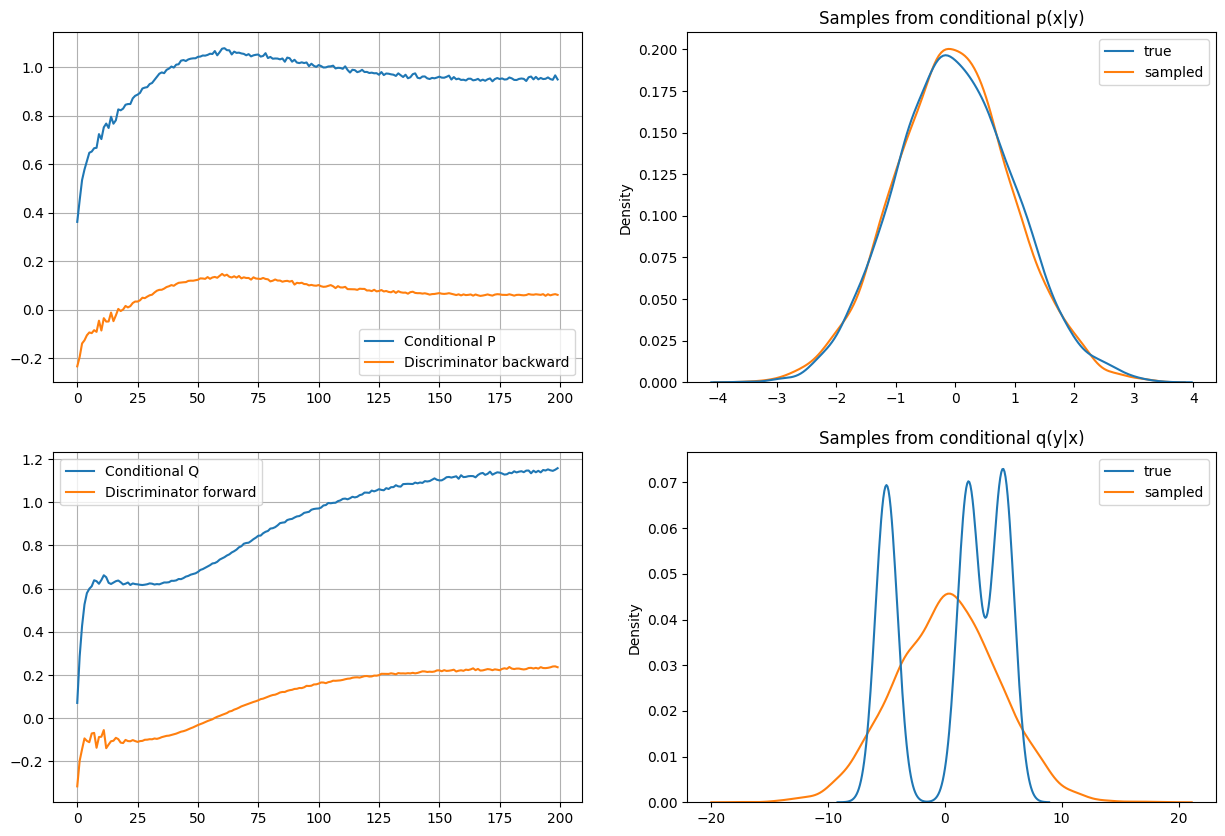

In [119]:
conditional_q.to('cpu')
conditional_p.to('cpu')

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# Plot losses
axs[0][0].plot(losses['cond_p'], label='Conditional P')
axs[0][0].plot(losses['disc_b'], label='Discriminator backward')
axs[0][0].grid()
axs[0][0].legend()

axs[1][0].plot(losses['cond_q'], label='Conditional Q')
axs[1][0].plot(losses['disc_f'], label='Discriminator forward')
axs[1][0].grid()
axs[1][0].legend()

# Plot samples 
n_samples = 4098
true_x = marginal_x.sample([n_samples, 1]).cpu()
true_y = marginal_y.sample([n_samples, 1]).cpu()

conditional_q.eval()
sampled_y = conditional_q(true_x).detach().numpy()
df_y = {'true': true_y.squeeze(), 'sampled': sampled_y.squeeze()}
df_y = pd.DataFrame(df_y)
sns.kdeplot(df_y, ax=axs[1][1])
axs[1][1].set_title("Samples from conditional q(y|x)")

conditional_p.eval()
sampled_x = conditional_p(true_y).detach().numpy()
df_x = {'true': true_x.squeeze(), 'sampled': sampled_x.squeeze()}
df_x = pd.DataFrame(df_x)
sns.kdeplot(df_x, ax=axs[0][1])
axs[0][1].set_title("Samples from conditional p(x|y)")

plt.show()